In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from copy import deepcopy as dc

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
df = pd.read_csv("AMZN.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [ ]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6516.000000,6516.000000,6516.000000,6516.000000,6516.000000,6.516000e+03
mean,31.611626,31.991995,31.193432,31.599740,31.599740,1.425338e+08
std,48.095343,48.659651,47.464476,48.060258,48.060258,1.401619e+08
min,0.070313,0.072396,0.065625,0.069792,0.069792,9.744000e+06
25%,1.998875,2.028500,1.964750,2.001250,2.001250,6.888182e+07
50%,6.456750,6.535500,6.353250,6.444250,6.444250,1.059050e+08
75%,38.451375,38.688000,38.203001,38.464625,38.464625,1.607700e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [ ]:
df_trim = df[["Date", "Close"]]

In [ ]:
df_trim["Date"] = pd.to_datetime(df_trim["Date"])

/var/folders/86/2cfgk86s0b5ck9yg4rt2y2f40000gn/T/ipykernel_11137/373635155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trim["Date"] = pd.to_datetime(df_trim["Date"])


In [ ]:
df_trim.iloc[0, 0]

Timestamp('1997-05-15 00:00:00')

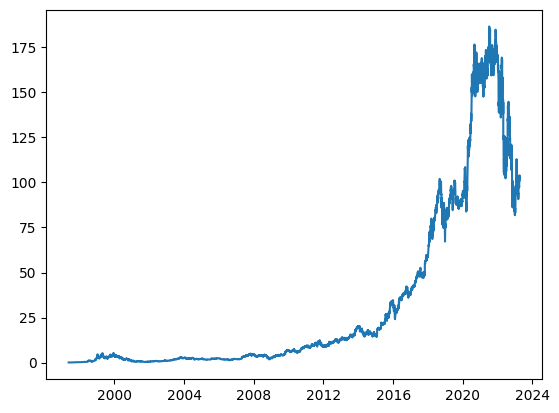

In [ ]:
plt.plot(df_trim["Date"], df_trim["Close"])

In [ ]:
def create_history_columns(df, n_steps):
    df_shifted = df.copy()
    for i in range(n_steps, 0, -1):
        df_shifted[f"Close_(t-{i})"] = [None] * len(df_shifted)
    
    for row in df_shifted.itertuples():
        if row[0] < n_steps:
            continue
            
        for i in range(n_steps, 0, -1): 
            df_shifted.iloc[row[0], 1 + i] = df_shifted.iloc[row[0]-i, 1]

    return df_shifted
history = 7
df_shifted = create_history_columns(df_trim, history)
df_shifted.set_index('Date', inplace=True)
df_shifted.dropna(how='any', inplace=True)
data_np = df_shifted.to_numpy()
df_shifted

,Close,Close_(t-7),Close_(t-6),Close_(t-5),Close_(t-4),Close_(t-3),Close_(t-2),Close_(t-1)
Date,,,,,,,,
1997-05-27,0.079167,0.075,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.07526,0.076563,0.079167,0.075,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075,0.07526,0.076563,0.079167,0.075,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.25,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.0,100.25,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.0,100.25,97.239998,98.040001,98.129997,98.709999


In [20]:
data_np

array([[0.079167, 0.075, 0.069792, ..., 0.085417, 0.086458, 0.097917],
       [0.076563, 0.079167, 0.075, ..., 0.081771, 0.085417, 0.086458],
       [0.07526, 0.076563, 0.079167, ..., 0.071354, 0.081771, 0.085417],
       ...,
       [102.410004, 103.290001, 102.0, ..., 98.040001, 98.129997,
        98.709999],
       [103.949997, 102.410004, 103.290001, ..., 97.239998, 98.040001,
        98.129997],
       [101.099998, 103.949997, 102.410004, ..., 100.25, 97.239998,
        98.040001]], dtype=object)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
data_np_scaled = scaler.fit_transform(data_np)
X = data_np_scaled[:, 1:]
y = data_np_scaled[:, 0]
X = torch.tensor(X).float().unsqueeze(dim=-1)
y = torch.tensor(y).float().unsqueeze(dim=-1)
X.shape, y.shape

(torch.Size([6509, 7, 1]), torch.Size([6509, 1]))

In [ ]:
split_index = int(len(X) * 0.9)
X_train, X_test = X[:split_index], X[split_index: ]
y_train, y_test = y[:split_index], y[split_index: ]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

In [ ]:
class StockPriceForecastDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
train_dataset = StockPriceForecastDataset(X_train, y_train)
test_dataset = StockPriceForecastDataset(X_test, y_test)

b_size = 32
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, stacked_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.stacked_layers = stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        b_size = x.shape[0]
        hidden_state = torch.zeros([self.stacked_layers, b_size, self.hidden_size]).to(device)
        cell_state = torch.zeros([self.stacked_layers, b_size, self.hidden_size]).to(device)
        # out - Hidden state of each timestep: (b_size, timesteps, hidden_size)
        # _ : Hidden state of the LSTM. Its a tuple of N tensors, one for the hidden state of each layer.
        out, _ = self.lstm(x, (hidden_state, cell_state))
        out = self.fc(out[:, -1, :])
        return out 

In [ ]:
model = LSTMModel(1, 16, 2)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [79]:
# Training 
lr = 0.001
epochs = 25
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train(True)
for epoch in range(epochs):
    print(f"Running Epoch {epoch+1}")
    running_loss = 0. 
    for index, batch in enumerate(train_loader):
        inp, gt = batch[0].to(device), batch[1].to(device)
        pred = model(inp)
        loss = loss_function(pred, gt)
        running_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if index > 0 and index % 50 == 0:
            avg_batch_loss = running_loss / 50.
            print(f"Batch: {index}, Average Loss: {avg_batch_loss}")
            running_loss = 0.

Running Epoch 1
Batch: 50, Average Loss: 0.32456082105636597
Batch: 100, Average Loss: 0.08312239497900009
Batch: 150, Average Loss: 0.03940052166581154
Running Epoch 2
Batch: 50, Average Loss: 0.006038331892341375
Batch: 100, Average Loss: 0.003561152843758464
Batch: 150, Average Loss: 0.003690361976623535
Running Epoch 3
Batch: 50, Average Loss: 0.002640080638229847
Batch: 100, Average Loss: 0.0017106832237914205
Batch: 150, Average Loss: 0.0017638197168707848
Running Epoch 4
Batch: 50, Average Loss: 0.0008359439088962972
Batch: 100, Average Loss: 0.0006185129750519991
Batch: 150, Average Loss: 0.0006608926341868937
Running Epoch 5
Batch: 50, Average Loss: 0.0006273026228882372
Batch: 100, Average Loss: 0.0005307505489327013
Batch: 150, Average Loss: 0.0005899721290916204
Running Epoch 6
Batch: 50, Average Loss: 0.0005201568710617721
Batch: 100, Average Loss: 0.0005329525447450578
Batch: 150, Average Loss: 0.0006030455697327852
Running Epoch 7
Batch: 50, Average Loss: 0.0004972014576

In [80]:
# Validation 
model.train(False)
running_loss = 0.

for index, batch in enumerate(test_loader):
    inp, gt = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        pred = model(inp)
        loss = loss_function(pred, gt)
        running_loss += loss

avg_batch_loss = running_loss / len(test_loader)
print(f"Test Loss: {avg_batch_loss}")

Test Loss: 0.012613922357559204


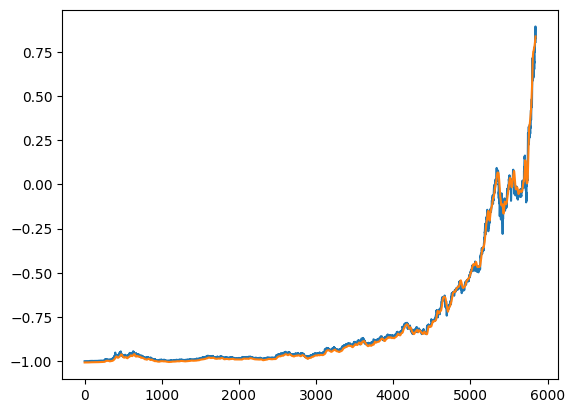

In [81]:
pred = model(X_train).detach().numpy()
plt.plot(y_train.numpy(), label="Actual_Close")
plt.plot(pred, label="Predicted_Close")
plt.show()

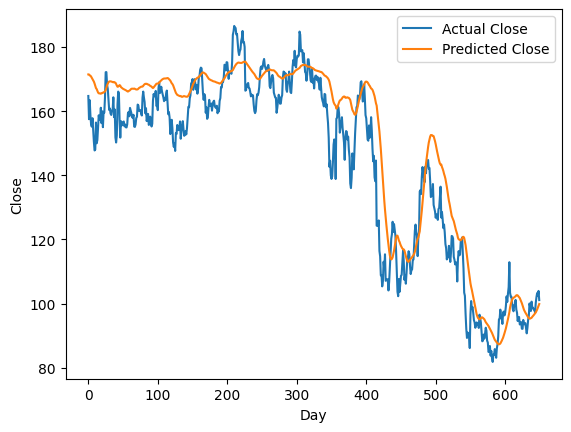

In [82]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], history+1))
dummies[:, 0] = test_predictions
dummies[:, 1] = y_test.numpy().flatten()
dummies = scaler.inverse_transform(dummies)
test_predictions = dc(dummies[:, 0])
actual = dc(dummies[:, 1])

plt.plot(actual, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()